In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from modules import *
import polars as pl
from itertools import chain
import os

succes


In [2]:
# TODO: evaluieren der korrekten window positionen unter zero indexing

# FIXME: Kernel crashed immer: Daten in chunks packen und streamen, in python file ausführen

# NOTE: NA printout currently disabled for debugging, must be looked into later, evaluate why identical bounds from paper are not robust to all parameter combinations
#cache decorator makes the functions non pickleable -> find 

### Testing influence of parameters on window indexes

[  0.   0.   6.  13.  20.  27.  34.  41.  48.  55.  62.  69.  76.  83.
  90.  97. 104. 111. 118. 125. 132. 139. 146. 153. 160. 167. 174. 181.
 188. 195. 202. 209. 216. 223. 230. 237. 244. 251. 258. 265. 272. 279.
 286. 293. 300. 307. 314. 321. 328. 335. 342. 349.]
[  8.  15.  22.  29.  36.  43.  50.  57.  64.  71.  78.  85.  92.  99.
 106. 113. 120. 127. 134. 141. 148. 155. 162. 169. 176. 183. 190. 197.
 204. 211. 218. 225. 232. 239. 246. 253. 260. 267. 274. 281. 288. 295.
 302. 309. 316. 323. 330. 337. 344. 351. 357. 357.]


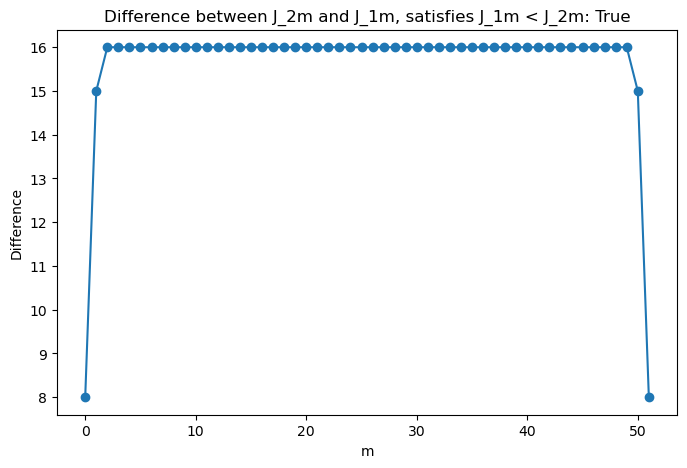

In [3]:

N = 364
b = 7
w = 16
M = int(np.ceil(N / b))

# Compute J_1m and J_2m
J_1m_values = np.maximum(0, np.minimum(np.arange(M) * b - w/2, N-b - w/2))# Shape: (M,)
print(J_1m_values)
J_2m_values = np.maximum(0, np.minimum(np.arange(M) * b + w/2, N-b))    # Shape: (M,)
print(J_2m_values)

# Compute the difference
difference = J_2m_values - J_1m_values

# Plot the difference
plt.figure(figsize=(8, 5))
plt.plot(range(M), difference, marker='o', linestyle='-', label='J_2m - J_1m')
plt.xlabel('m')
plt.ylabel('Difference')
plt.title(f'Difference between J_2m and J_1m, satisfies J_1m < J_2m: {~np.any(J_1m_values >= J_2m_values)}')
plt.show()

# Metrics
Mathematical formulation for discrete Wasserstein Distance, with $q$ being the quantiles:
$$
W_p(\mu_1, \mu_2) = \left( \int_0^1 \left| F_1^{-1}(q) - F_2^{-1}(q) \right|^p \, dq \right)^{\frac{1}{p}}
$$


In [ ]:
class GridEvaluation:

    output_file = "results/grid_results.csv"
    max_window_size = 60
    max_block_size = 30
    max_twin_number = 10
    batch_size = 5

    @staticmethod
    def evaluate_lbb(test_item_key, b, w):

        twin_lbb = Resampling.lb_bootstrap(InputData.TwinData[test_item_key], window_size = w, block_size = b)
        test_lbb = Resampling.lb_bootstrap(InputData.TestData[test_item_key], window_size = w, block_size = b)

        summary = {
            "TEST_ITEM_COMMUNICATIONKEY": test_item_key,
            "BLOCK_SIZE": b,
            "WINDOW_SIZE": w,
            "TWIN_NUMBER": InputData.TwinData[test_item_key].shape[1],
            "MEAN_SAMPLE": np.mean(twin_lbb),
            "MEAN_TEST": np.mean(InputData.TestData[test_item_key]),
            "RMSE": np.sqrt(Metrics.rmse(InputData.TestData[test_item_key], twin_lbb)),
            "MAPE": Metrics.mape(InputData.TestData[test_item_key], twin_lbb),
            "MAE": Metrics.mae(InputData.TestData[test_item_key], twin_lbb),
            "WASSERSTEIN": Metrics.discrete_wasserstein(test_lbb, twin_lbb),
        }
        return summary
    
    @staticmethod
    def evaluate_idd(test_item_key):
        
        twin_idd = Resampling.iid_bootstrap(InputData.TwinData[test_item_key])
        test_idd = Resampling.iid_bootstrap(InputData.TestData[test_item_key])

        summary = {
            "TEST_ITEM_COMMUNICATIONKEY": test_item_key,
            "BLOCK_SIZE": 1,
            "WINDOW_SIZE": 1,
            "TWIN_NUMBER": InputData.TwinData[test_item_key].shape[1],
            "MEAN_SAMPLE": np.mean(twin_idd),
            "MEAN_TEST": np.mean(InputData.TestData[test_item_key]),
            "RMSE": Metrics.rmse(InputData.TestData[test_item_key], twin_idd),
            "MAPE": Metrics.mape(InputData.TestData[test_item_key], twin_idd),
            "MAE": Metrics.mae(InputData.TestData[test_item_key], twin_idd),
            "WASSERSTEIN": Metrics.discrete_wasserstein(test_idd, twin_idd),
        }
        return summary
    
    @classmethod
    def write_results(cls, results):
        df = pd.DataFrame(results)
        df.to_csv(cls.output_file, mode="a", header=not os.path.exists(cls.output_file), index=False)
    
    @classmethod
    def run(cls, keys):

        batches = [keys[i:i + cls.batch_size] for i in range(0, len(keys), cls.batch_size)]
        grid = [(w, b, cls.max_twin_number) for b in range(1, cls.max_block_size + 1, 3) for w in range(1, cls.max_window_size + 1, 4)]

        for batch in tqdm(batches, desc="Batch processing and streaming"):
            
            #hier wir parallelisiert sein Vater auf meinen 8 Kirschkernen
            cls.write_results(Parallel(n_jobs=-1)(
            delayed(cls.evaluate_lbb)(test_item_key, b, w) 
            for w, b, _ in grid 
            for test_item_key in batch
        ))

In [6]:
GridEvaluation.run(list(InputData.TestData.keys()))

Batch processing and streaming:   0%|          | 0/20 [00:00<?, ?it/s]

succes
succes
succes
succes
succes
succes
succes
succes


# Error Diagnosis

### 1. Optimierung der Parameter
- **Frage:** Was ist die beste Parameterkombination?

### 2. Identifikation von Ausreißern
- **Frage:** Welche Items sind die größten Ausreißer?

### 3. Bias-Analyse
- **Frage:** Haben wir allgemein einen positiven oder negativen Bias? (Test if correction factor might help)

### 4. Einfluss von Parametern auf Bias und Varianz
- **Frage:** Ändern sich Bias und Varianz mit den Parametern, insbesondere mit der Anzahl der Twins?

### 5. Vergleich mit Bootstrap
- **Frage:** Lohnt sich das im Vergleich zum einfachen Bootstrap?

### 6. Ausblick auf Performance-Änderungen
- **Frage:** Wie ändert sich die Performance, wenn die Beobachtungsperiode um 1 Jahr verschoben wird?
  - **Erwartung:** Der Einfluss des Trends wird erhöht.

In [ ]:
#1
df_results.groupby(["window_size", "block_size", "num_twins"]).median().sort_values("MSE").reset_index()[["window_size", "block_size", "num_twins", "MSE" ]]

NameError: name 'df_results' is not defined

In [ ]:
df_results.groupby(["window_size", "block_size", "num_twins"]).mean().sort_values("MSE").reset_index()[["window_size", "block_size", "num_twins", "MSE" ]]

In [ ]:
#2 größten ausreißer
df_results.groupby(["TEST_ITEM_COMMUNICATIONKEY"]).mean().sort_values("MSE", ascending=False).reset_index()[["TEST_ITEM_COMMUNICATIONKEY", "MSE"]]

In [ ]:
# Bias Analyse
#müssen wir einzeln abfragen -> Dann mit lineplot die entwicklung über die twin_nr zeigen

# Normality test
- clt is defined for iid data
- distributions moments must be finite?
- tune number of iteration until distribution is normal -> helps simplify methods of robust optimization

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(results_simple, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(results_simple), max(results_simple), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(results_simple)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [ ]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05

In [ ]:
#generate integer samples from normal distribution
norm_samples = np.random.normal(50, 25, 100000).astype(int)

In [ ]:
norm_samples = np.random.normal(50, 5, 100000).astype(int)
_, p_value = stats.normaltest(norm_samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does NOT appear to be normally distributed.")

In [ ]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(results_simple)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")